In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!pip install visualkeras
!pip install tensorflow-addons

In [3]:

import os
import warnings
import itertools
import cv2
import seaborn as sns
import pandas as pd
import numpy  as np
from PIL import Image
from sklearn.utils import class_weight
from sklearn.metrics import confusion_matrix, classification_report
from collections import Counter

import tensorflow as tf
import tensorflow_addons as tfa
import visualkeras
import plotly.express as px
import matplotlib.pyplot as plt
from sklearn.metrics import multilabel_confusion_matrix
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import plot_model
from tensorflow.keras import layers
from tensorflow.keras import regularizers
from sklearn.model_selection   import train_test_split
from keras.preprocessing.image import ImageDataGenerator

warnings.filterwarnings('ignore')
%matplotlib inline

/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [4]:
# General parameters
epochs = 15
pic_size = 240
np.random.seed(42)
tf.random.set_seed(42)

In [5]:
import os
import cv2
from PIL import Image
import numpy as np

no_images = os.listdir('/content/drive/MyDrive/brain_tumor_dataset/no')
yes_images = os.listdir('/content/drive/MyDrive/brain_tumor_dataset/yes')
dataset = []
lab = []

for image_name in no_images:
    image = cv2.imread(os.path.join('/content/drive/MyDrive/brain_tumor_dataset/no', image_name))
    image = Image.fromarray(image, 'RGB')
    image = image.resize((240, 240))
    dataset.append(np.array(image))
    lab.append(0)

for image_name in yes_images:
    image = cv2.imread(os.path.join('/content/drive/MyDrive/brain_tumor_dataset/yes', image_name))
    image = Image.fromarray(image, 'RGB')
    image = image.resize((240, 240))
    dataset.append(np.array(image))
    lab.append(1)



In [6]:
dataset = np.array(dataset)
lab = np.array(lab)
print(dataset.shape, lab.shape)

(3010, 240, 240, 3) (3010,)


In [7]:
x_train, x_test, y_train, y_test = train_test_split(dataset, lab, test_size=0.20, shuffle=True, random_state=42)

In [8]:
def plot_state(state):
    plt.figure(figsize= (12,12))
    for i in range(1, 10, 1):
        plt.subplot(3,3,i)
        img = load_img( "/" + state + "/" + os.listdir("/" + state)[i], target_size=(pic_size, pic_size))
        plt.imshow(img)
    plt.show()

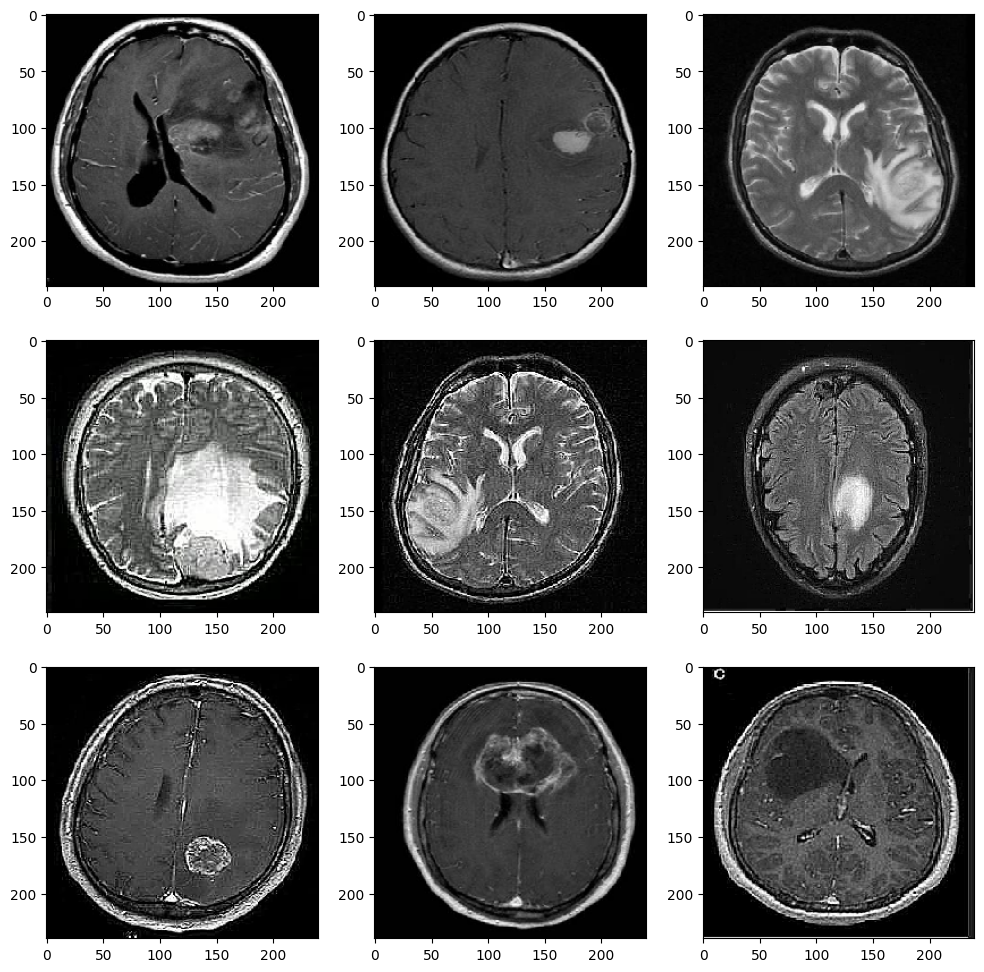

In [9]:
plot_state('/content/drive/MyDrive/brain_tumor_dataset/yes')

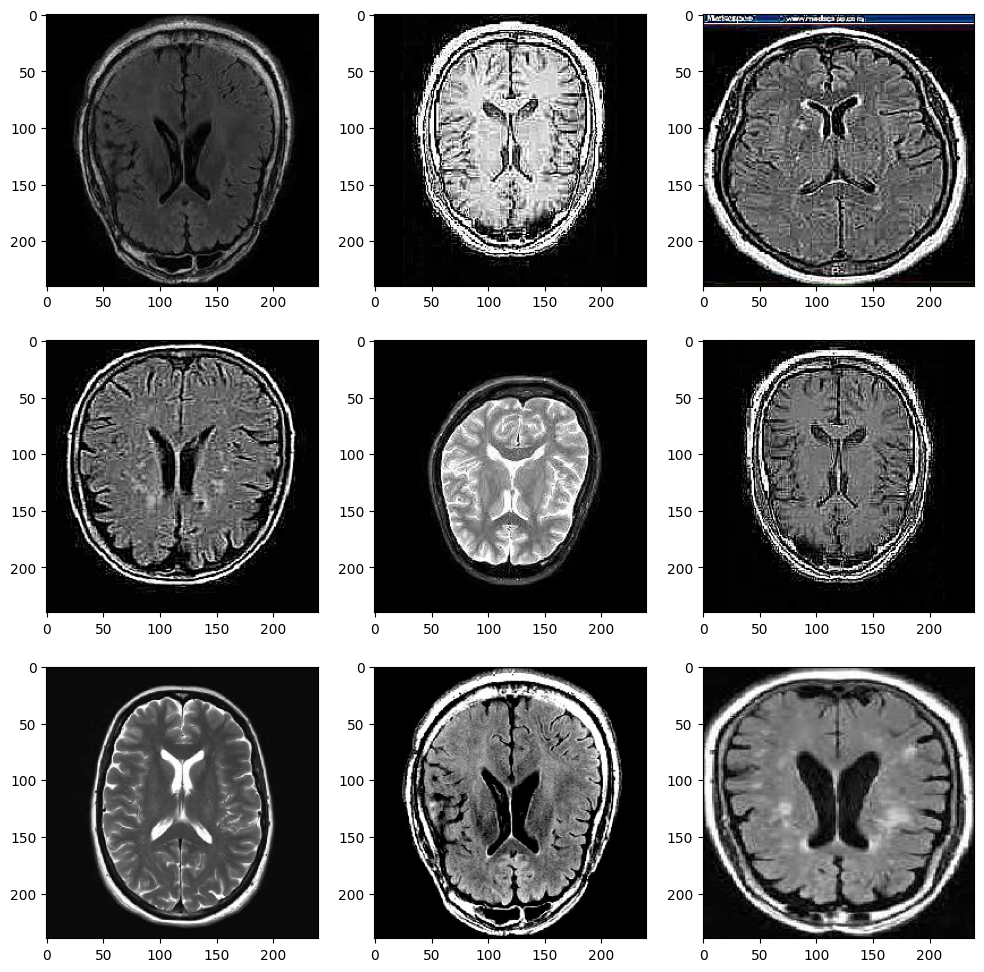

In [10]:
plot_state('/content/drive/MyDrive/brain_tumor_dataset/no')

In [11]:
learning_rate = 0.001
weight_decay = 0.0001
batch_size = 64
num_epochs = 50
image_size = 240  # We'll resize input images to this size
patch_size = 20  # Size of the patches to be extract from the input images
num_patches = (image_size // patch_size) ** 2
projection_dim = 64
num_heads = 4
transformer_units = [
    projection_dim * 2,
    projection_dim,
]  # Size of the transformer layers
transformer_layers = 8
mlp_head_units = [2048, 1024]  # Size of the dense layers of the final classifier

In [12]:
def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation=tf.nn.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x

In [13]:
class Patches(layers.Layer):
    def __init__(self, patch_size):
        super(Patches, self).__init__()
        self.patch_size = patch_size

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches

Image size: 240 X 240
Patch size: 20 X 20
Patches per image: 144
Elements per patch: 1200


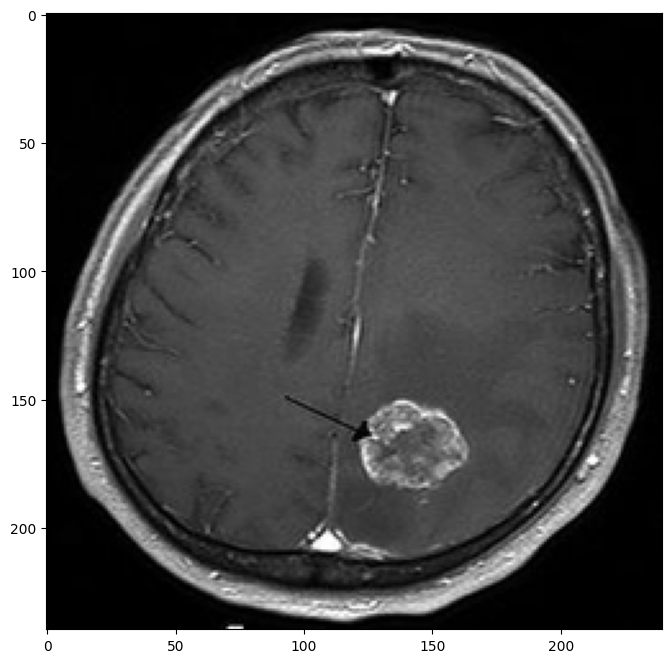

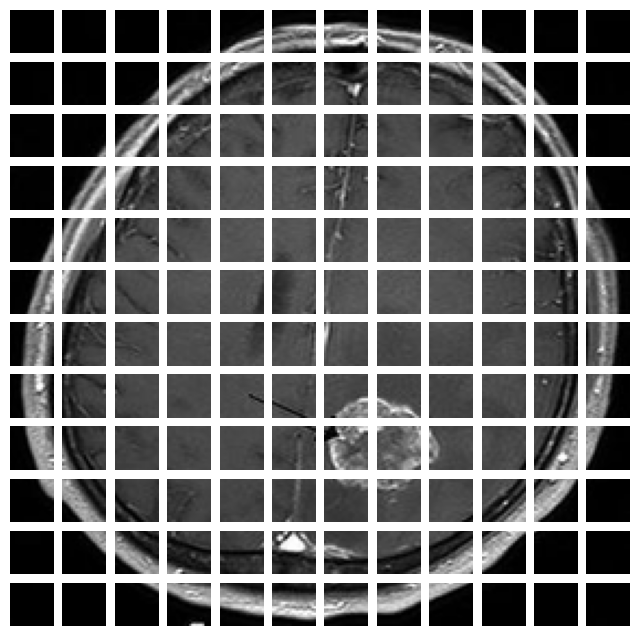

In [14]:
plt.figure(figsize=(8, 8))
image = x_train[np.random.choice(range(x_train.shape[0]))]
plt.imshow(image.astype("uint8"))

resized_image = tf.image.resize(
    tf.convert_to_tensor([image]), size=(image_size, image_size)
)
patches = Patches(patch_size)(resized_image)
print(f"Image size: {image_size} X {image_size}")
print(f"Patch size: {patch_size} X {patch_size}")
print(f"Patches per image: {patches.shape[1]}")
print(f"Elements per patch: {patches.shape[-1]}")

n = int(np.sqrt(patches.shape[1]))
plt.figure(figsize=(8, 8))
for i, patch in enumerate(patches[0]):
    ax = plt.subplot(n, n, i + 1)
    patch_img = tf.reshape(patch, (patch_size, patch_size, 3))
    plt.imshow(patch_img.numpy().astype("uint8"))
    plt.axis("off")

In [15]:
class PatchEncoder(tf.keras.layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super(PatchEncoder, self).__init__()
        self.num_patches = num_patches
        self.projection = layers.Dense(units=projection_dim)
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )

    def call(self, patch):
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        encoded = self.projection(patch) + self.position_embedding(positions)
        return encoded

In [16]:

# Building the ViT
def create_vit_classifier():
    inputs = layers.Input(shape=(240, 240, 3))
    # Augment data.
    # augmented = data_augmentation(inputs)
    # Create patches.
    patches = Patches(patch_size)(inputs)
    # Encode patches.
    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)

    # Create multiple layers of the Transformer block.
    for _ in range(transformer_layers):
        # Layer normalization 1.
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        # Create a multi-head attention layer.
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=projection_dim, dropout=0.1
        )(x1, x1)
        # Skip connection 1.
        x2 = layers.Add()([attention_output, encoded_patches])
        # Layer normalization 2.
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        # MLP.
        x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=0.1)
        # Skip connection 2.
        encoded_patches = layers.Add()([x3, x2])

    # Create a [batch_size, projection_dim] tensor.
    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = layers.Flatten()(representation)
    representation = layers.Dropout(0.5)(representation)
    # Add MLP.
    features = mlp(representation, hidden_units=mlp_head_units, dropout_rate=0.5)
    # Classify outputs.
    #logits = layers.Dense(7)(features)
    logits = layers.Dense(2)(features)
    # Create the Keras model.
    model = tf.keras.Model(inputs=inputs, outputs=logits)
    return model




In [17]:

def run_experiment(model):
    optimizer = tfa.optimizers.AdamW(
        learning_rate=learning_rate, weight_decay=weight_decay
    )

    model.compile(
        optimizer=optimizer,
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=[
            tf.keras.metrics.SparseCategoricalAccuracy(name="accuracy"),
            tf.keras.metrics.SparseTopKCategoricalAccuracy(5, name="top-5-accuracy"),
        ],
    )

    checkpoint_filepath = "/tmp/checkpoint"
    checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
        checkpoint_filepath,
        monitor="val_accuracy",
        save_best_only=True,
        save_weights_only=True,
    )

    history = model.fit(
        x=x_train,
        y=y_train,
        batch_size=batch_size,
        epochs=num_epochs,
        validation_data=(x_test, y_test),
        callbacks=[checkpoint_callback],
    )

    model.load_weights(checkpoint_filepath)
    _, accuracy, top_5_accuracy = model.evaluate(x_test, y_test)
    print(f"Test accuracy: {round(accuracy * 100, 2)}%")
    print(f"Test top 5 accuracy: {round(top_5_accuracy * 100, 2)}%")

    return history

In [18]:
vit_classifier = create_vit_classifier()
vit_history = run_experiment(vit_classifier)

Epoch 1/50
38/38 [==============================] - 33s 190ms/step - loss: 2.5936 - accuracy: 0.5502 - top-5-accuracy: 1.0000 - val_loss: 0.8037 - val_accuracy: 0.5631 - val_top-5-accuracy: 1.0000
Epoch 2/50
38/38 [==============================] - 6s 156ms/step - loss: 0.7768 - accuracy: 0.6321 - top-5-accuracy: 1.0000 - val_loss: 0.5289 - val_accuracy: 0.7874 - val_top-5-accuracy: 1.0000
Epoch 3/50
38/38 [==============================] - 5s 121ms/step - loss: 0.5949 - accuracy: 0.7093 - top-5-accuracy: 1.0000 - val_loss: 0.5072 - val_accuracy: 0.7874 - val_top-5-accuracy: 1.0000
Epoch 4/50
38/38 [==============================] - 4s 118ms/step - loss: 0.4882 - accuracy: 0.7687 - top-5-accuracy: 1.0000 - val_loss: 0.4785 - val_accuracy: 0.7625 - val_top-5-accuracy: 1.0000
Epoch 5/50
38/38 [==============================] - 6s 162ms/step - loss: 0.4945 - accuracy: 0.7753 - top-5-accuracy: 1.0000 - val_loss: 0.4367 - val_accuracy: 0.8073 - val_top-5-accuracy: 1.0000
Epoch 6/50
38/38 [=

In [20]:
from tensorflow.keras.models import load_model
# After training the model and saving its history
vit_classifier.save('/content/drive/MyDrive/fyp__brain_tumor_detection_vitl.h5')